### 지도학습 용어 정리
_참고: PDF 1.1-1.2 잠시 용어_
분류와 회귀의 차이를 코드로 정리하면서 필요 모듈을 불러옵니다.


In [1]:
# 분류/회귀 개념 요약과 필수 모듈 로드
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path
import urllib.request

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_openml

sns.set_theme(style='whitegrid')

FONT_DIR = Path.home() / '.cache' / 'fonts'
FONT_PATH = FONT_DIR / 'NanumGothic.ttf'
FONT_URL = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'

if not FONT_PATH.exists():
    FONT_DIR.mkdir(parents=True, exist_ok=True)
    urllib.request.urlretrieve(FONT_URL, FONT_PATH)
font_manager.fontManager.addfont(str(FONT_PATH))
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

learning_tasks = {
    'classification': '꽃 품종 구분 (setosa vs versicolor vs virginica)',
    'regression': '주택 면적을 이용한 가격 예측 (연속값)'
}
learning_tasks


{'classification': '꽃 품종 구분 (setosa vs versicolor vs virginica)',
 'regression': '주택 면적을 이용한 가격 예측 (연속값)'}

### 손으로 Cost Function: 데이터 설정
_참고: PDF 2.1-2.4 이번에도 손으로 Cost Function_
주택 면적-가격 toy 데이터를 만들고 분포를 확인합니다.


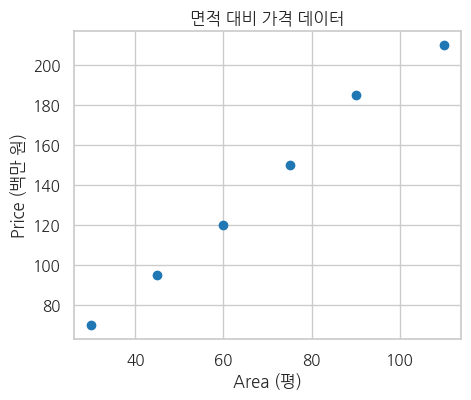

,area,price
0,30,70
1,45,95
2,60,120
3,75,150
4,90,185
5,110,210


In [2]:
# Toy 데이터 생성 및 산점도
house_df = pd.DataFrame({
    'area': [30, 45, 60, 75, 90, 110],
    'price': [70, 95, 120, 150, 185, 210]
})

plt.figure(figsize=(5, 4))
plt.scatter(house_df['area'], house_df['price'], color='tab:blue')
plt.title('면적 대비 가격 데이터')
plt.xlabel('Area (평)')
plt.ylabel('Price (백만 원)')
plt.show()
house_df


### 선형 모델 가정과 두 가지 시도
_참고: PDF 2.5-2.14 모델 시도 비교_
임의 파라미터 조합으로 예측과 잔차를 구해봅니다.


In [3]:
# 두 가지 파라미터 시도로 예측 및 잔차 비교
X = house_df['area'].values
y = house_df['price'].values

h = lambda theta0, theta1, x: theta0 + theta1 * x
candidates = [
    {'theta0': 20, 'theta1': 1.8},
    {'theta0': 5, 'theta1': 2.0},
]

rows = []
for cand in candidates:
    preds = h(cand['theta0'], cand['theta1'], X)
    errors = preds - y
    rows.append({
        'theta0': cand['theta0'],
        'theta1': cand['theta1'],
        'errors': errors,
    })
rows


[{'theta0': 20,
  'theta1': 1.8,
  'errors': array([ 4.,  6.,  8.,  5., -3.,  8.])},
 {'theta0': 5, 'theta1': 2.0, 'errors': array([-5.,  0.,  5.,  5.,  0., 15.])}]

### Cost Function 계산
_참고: PDF 2.15-2.19 에러 제곱과 평균_
잔차 제곱 평균(MSE)을 통해 J(θ)를 계산합니다.


In [4]:
# Cost Function 정의 및 계산
m = len(y)

def cost(theta0, theta1):
    preds = h(theta0, theta1, X)
    return (1 / (2 * m)) * np.sum((preds - y) ** 2)

for cand in rows:
    cand['J'] = cost(cand['theta0'], cand['theta1'])
rows


[{'theta0': 20,
  'theta1': 1.8,
  'errors': array([ 4.,  6.,  8.,  5., -3.,  8.]),
  'J': np.float64(17.833333333333332)},
 {'theta0': 5,
  'theta1': 2.0,
  'errors': array([-5.,  0.,  5.,  5.,  0., 15.]),
  'J': np.float64(25.0)}]

### Cost 최소화 탐색 (격자 검색)
_참고: PDF 2.20-2.24 최솟값 찾기_
여러 θ 조합을 순회해 Cost가 가장 작은 지점을 찾습니다.


In [5]:
# 격자 검색으로 최적 Cost 추정
theta0_vals = np.linspace(-20, 40, 200)
theta1_vals = np.linspace(1.0, 3.0, 200)

best = None
for t0 in theta0_vals:
    for t1 in theta1_vals:
        j = cost(t0, t1)
        if best is None or j < best['J']:
            best = {'theta0': t0, 'theta1': t1, 'J': j}
best


{'theta0': np.float64(14.371859296482413),
 'theta1': np.float64(1.814070351758794),
 'J': np.float64(6.879140257400936)}

### Sympy로 분석적 최적값 구하기
_참고: PDF 2.25-2.30 Symbolic 연산_
Symbolic 미분으로 파라미터의 해를 직접 구합니다.


In [6]:
# Sympy를 활용한 해석적 해
import sympy as sp

'theta0_sym, theta1_sym = sp.symbols('theta0_sym theta1_sym', real=True)
i = sp.symbols('i', integer=True)
J_expr = (1 / (2 * m)) * sp.Sum((theta0_sym + theta1_sym * X[i] - y[i]) ** 2, (i, 0, m - 1))
J_simplified = sp.simplify(J_expr.doit())
solutions = sp.solve([
    sp.diff(J_simplified, theta0_sym),
    sp.diff(J_simplified, theta1_sym)
], (theta0_sym, theta1_sym))
solutions


SyntaxError: unterminated string literal (detected at line 4) (3415950025.py, line 4)

### Cost Function 시각화
_참고: PDF 3.1-3.4 Cost Function 시각 자료_
θ 공간의 J(θ) 값을 등고선으로 표현합니다.


In [ ]:
# Cost 등고선 시각화
theta0_grid, theta1_grid = np.meshgrid(
    np.linspace(-20, 40, 120),
    np.linspace(1.0, 3.0, 120)
)

J_grid = np.zeros_like(theta0_grid)
for i in range(theta0_grid.shape[0]):
    for j in range(theta0_grid.shape[1]):
        J_grid[i, j] = cost(theta0_grid[i, j], theta1_grid[i, j])

plt.figure(figsize=(6, 5))
contour = plt.contour(theta0_grid, theta1_grid, J_grid, levels=20, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)
plt.scatter(best['theta0'], best['theta1'], color='red', label='Best (grid)')
plt.title('Cost Function Contour')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.legend()
plt.show()


### Gradient Descent 구현
_참고: PDF 4.1-4.7 Gradient Descent_
학습률을 조절하며 경사하강법으로 θ를 업데이트합니다.


In [ ]:
# 경사하강법 구현
def gradient_descent(alpha=0.0005, iters=500):
    theta0 = 0.0
    theta1 = 0.0
    history = []
    for _ in range(iters):
        preds = h(theta0, theta1, X)
        error = preds - y
        theta0 -= alpha * (1 / m) * np.sum(error)
        theta1 -= alpha * (1 / m) * np.sum(error * X)
        history.append((theta0, theta1, cost(theta0, theta1)))
    return history

gd_history = gradient_descent(alpha=0.0008, iters=800)
print('Last state:', gd_history[-1])

plt.figure(figsize=(5, 3))
plt.plot([state[2] for state in gd_history])
plt.title('Gradient Descent Cost History')
plt.xlabel('Iteration')
plt.ylabel('J(θ)')
plt.show()


### 다변수 회귀 행렬 표현
_참고: PDF 5.1-5.2 다변수 데이터 표현_
여러 특성을 포함하는 디자인 행렬과 Normal Equation 해를 계산합니다.


In [ ]:
# 다변수 회귀 예시와 Normal Equation
multi_df = pd.DataFrame({
    'area': [30, 60, 90, 120],
    'rooms': [2, 3, 4, 5],
    'age': [30, 25, 20, 15],
    'price': [80, 130, 185, 240]
})
X_multi = multi_df[['area', 'rooms', 'age']].values
y_multi = multi_df['price'].values
X_b = np.c_[np.ones(len(X_multi)), X_multi]

theta_closed = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y_multi
pd.Series(theta_closed, index=['theta0', 'theta_area', 'theta_rooms', 'theta_age'])


### Boston 집값 데이터 살펴보기
_참고: PDF 6.1-6.9 데이터 읽기/관찰_
OpenML에서 Boston 데이터를 가져와 기본 통계를 확인합니다.


In [ ]:
# Boston 데이터 불러오기 및 기본 통계
boston = fetch_openml(name='boston', version=1, as_frame=True)
boston_df = boston.frame.rename(columns={'MEDV': 'PRICE'})
boston_df.describe().T[['mean', 'std', 'min', 'max']]


### 특성 상관과 시각화
_참고: PDF 6.7-6.10 상관 분석_
상관계수를 계산하고 RM/LSTAT과 가격의 관계를 시각화합니다.


In [ ]:
# 상관계수와 주요 특성 시각화
corr = boston_df.corr(numeric_only=True)['PRICE'].sort_values(ascending=False)
print(corr.head())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(boston_df['RM'], boston_df['PRICE'], s=20, alpha=0.6)
axes[0].set_title('RM vs PRICE')
axes[0].set_xlabel('RM')
axes[0].set_ylabel('PRICE')
axes[1].scatter(boston_df['LSTAT'], boston_df['PRICE'], s=20, alpha=0.6, color='tab:orange')
axes[1].set_title('LSTAT vs PRICE')
axes[1].set_xlabel('LSTAT')
axes[1].set_ylabel('PRICE')
plt.tight_layout()
plt.show()


### 다중 선형회귀 학습과 평가
_참고: PDF 6.11-6.14 LinearRegression 활용_
선택한 특성으로 모델을 학습하고 RMSE로 성능을 확인합니다.


In [ ]:
# 두 특성을 이용한 선형회귀 학습 및 평가
features = ['RM', 'LSTAT']
X = boston_df[features]
y = boston_df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE (RM + LSTAT):', rmse)
print('Coefficients:', pd.Series(model.coef_, index=features))


### 단일 특성 실험 비교
_참고: PDF 6.15-6.18 특성 선택 고민_
LSTAT 단일 특성만 사용했을 때의 성능 저하를 비교합니다.


In [ ]:
# LSTAT 단일 특성으로 다시 학습해 비교
X_single = boston_df[['LSTAT']]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_single, y, test_size=0.2, random_state=42
)

single_model = LinearRegression()
single_model.fit(X_train_s, y_train_s)

single_pred = single_model.predict(X_test_s)
single_rmse = mean_squared_error(y_test_s, single_pred, squared=False)
print('RMSE (LSTAT only):', single_rmse)
print('Coefficient:', single_model.coef_[0])
